### Import Libraries

In [187]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

import string
import torch
# import pickle5 as pickle
import pickle
from heapq import nlargest
import sys
import spacy
# !pip install truecase
import truecase
from spacy import displacy
from collections import Counter
from nltk.tag import StanfordNERTagger
import en_core_web_sm
nlp = en_core_web_sm.load()
from pprint import pprint
# !pip install unidecode
from unidecode import unidecode
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel, euclidean_distances
import warnings
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.spatial import distance
import numpy as np
import re
# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.cluster.util import cosine_distance
import tensorflow as tf
import transformers
from sent2vec.vectorizer import Vectorizer as S2vectorizer
tqdm_notebook.pandas()
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import networkx as nx

#import pipelines
from transformers import pipeline
nlp2 = pipeline("question-answering")

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', 0)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing

In [211]:
stop_words = stopwords.words("english")

def clean_normalcase_stop_lem(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    text = ' '.join([wordnet_lemmatizer.lemmatize(i) for i in text.split()])
    return text

def clean_normalcase_nostop_lem(text):
    text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    return text

def clean_lowercase_stop_lem(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    text = ' '.join([wordnet_lemmatizer.lemmatize(i) for i in text.split()])
    return text.lower()

def clean_lowercase_nostop_lem(text):
    text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
#     text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    return text.lower()

def clean_lowercase_nostop(text):
    text = ' '.join([word for word in text.split() if word not in stop_words])
#     text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    return text.lower()

## NER Generation

In [212]:
pprint([(X.text, X.label_) for X in nlp("America is a country").ents])

[('America', 'GPE')]


In [213]:
def generate_ners(text):
    result = set()
    for X in nlp(text).ents:
        result.add(unidecode(X.text.lower()))
    print(f"NERs: {result}")
    print('------------------')
    return result

In [214]:
df = pd.read_csv('../data/legal_squad_data.csv')

In [215]:
df = df.drop_duplicates(subset=['context'])
# df = df.dropna(subset=['doc'])
df['ners'] = df['context'].progress_apply(generate_ners)
# df['context'] = df['context'].apply(lambda x: str(x).lower())

  0%|          | 0/1080 [00:00<?, ?it/s]

NERs: {'new york', 'first', 'the supreme court of', 'the united states', 'the constitution of the united states', 'federal hall on wall street', 'the articles of confederation', '1789', 'united states', 'congress', 'the congress of the confederation', '1790', '1785', 'philadelphia', 'u.s.', 'george washington'}
------------------
NERs: {"new york's", 'new york', 'william f. buckley', 'trump', '2016', 'one', 'weeks', '1955', 'republican', 'america', 'january 2016', '9/11', 'donald trump', 'the national review'}
------------------
NERs: {'the united states', '35,000', 'finest', "new york's", 'the new york city police department (nypd'}
------------------
NERs: {'four-year', 'the new york city administrative code', 'the city record', '51', 'new york city', 'the city council', 'three', 'four years'}
------------------
NERs: {'barack obama', 'first', '67%', 'november 2008', '1924', '2012', 'democrat', 'democrats', 'new york city', 'calvin coolidge', 'republican', 'the democratic party', 'fi

NERs: {'murray', 'the united states', 'hoboken land & improvement co.', 'congress', '1856', 'lessee', 'the supreme court'}
------------------
NERs: {'two-thirds', 'senate', 'two', 'congress'}
------------------
NERs: {'senate', 'the house of representatives'}
------------------
NERs: {'navy', 'the united states', 'senate', 'congress', 'army'}
------------------
NERs: {'the federalist papers', 'marbury', 'constitution', 'madison', 'the supreme court'}
------------------
NERs: {'court of appeals', 'supreme court', 'the supreme court'}
------------------
NERs: {'the supreme court', 'congress'}
------------------
NERs: {'senate'}
------------------
NERs: {'constitution', 'federalist 51', 'james madison', 'republican'}
------------------
NERs: {'republicans', 'the civil war', 'the 20th century', 'one', 'johnson', 'congress', 'america', 'the tenure of office act', 'three'}
------------------
NERs: {'first', 'indian removal', 'twelve', 'one', 'seventh', 'john quincy adams', 'the supreme court

------------------
NERs: {'the federal reserve bank of boston', "thomas p. o'neill federal building", 'the united states court of appeals', 'the district of massachusetts', 'the united states district court', 'john f. kennedy', 'the first circuit'}
------------------
NERs: {'john kerry', 'first', 'state', 'democrat', '1998', 'united states', 'democrats', 'elizabeth warren', 'boston', 'fourth', 'over a century', 'mike capuano', 'three-fourths', 'republican', 'ed markey', '2013', 'senate', '8th', 'kerry', 'two', 'stephen lynch', '2012', '7th'}
------------------
NERs: {'snider', 'stephanie sperber', 'focus features', 'viacom', 'dreamworks', 'universal partnerships & licensing', 'late 2005', 'marc shmuger', 'october 5, 2009', 'universal pictures', 'jeff shell', '2009', 'nbcuniversal international chairman', 'david linde', 'adam fogelson', 'nbcuniversal', 'early 2006', 'september 2013', 'steve burke', 'ron meyer', 'stacey snider', 'ge', 'universal parks and resorts', 'paramount pictures', 

NERs: {'galeb', '32', '727', 'boeing', 'karadordevo', 'aviogenex', 'lake bled', 'the blue train', 'tito', 'serbian', 'two decades', 'montenegro', 'yugoslav', '1974'}
------------------
NERs: {'twenty-four', 'rmi', 'one', 'nitijela', 'marshallese', 'every four years', 'constitution', '1979', 'five', '33', 'four', 'the marshall islands', '18'}
------------------
NERs: {'twenty-four', 'aka', 'udp', 'united democratic party', 'the council of iroij', 'aelon kein ad', 'twelve', 'nitijela', 'the marshall islands', "united people's party", 'parliament', 'the presidential cabinet', 'four', 'kea', 'kien eo am', 'ten'}
------------------
NERs: {'the international labour organization', 'the marshall islands', '2007'}
------------------
NERs: {'polish', "the thirteen years' war", 'sejm', 'the nieszawa statutes', '1454', 'casimir iv'}
------------------
NERs: {'first', 'polish', 'john i albert', 'the jagiellonian dynasty', '1492', 'casimir ii'}
------------------
NERs: {'latin', 'polish', 'commonwea

NERs: {'g. casavantes', 'trevino', 'may 1880', 'diaz', 'six cents to', 'august 1879', 'durango', 'two cents', 'chihuahua', 'trias', 'coahuila', 'sierra mojada', 'mexico city'}
------------------
NERs: {'arab', 'ghaybat al-sughra', 'al-arba`a', 'al-mahdi', 'four', 'the minor occultation'}
------------------
NERs: {'democrat', 'houston', 'sylvester turner', 'texas', 'the houston city council', '16'}
------------------
NERs: {'first', 'democrats', 'about 62 percent', '68 percent', 'houston', 'non-hispanic', '89 percent', 'republican', '2009', 'annise parker', 'texas', 'us', 'houston area survey', 'harris county', 'republicans', 'hispanics', '1 million', 'democratic', '2005'}
------------------
NERs: {'himachal', 'ridge maidan', '25 december 2012', 'bjp', 'only 26', 'november 2012', 'virbhadra singh', 'congress', 'shimla', "himachal pradesh's", 'sixth', 'five', '36', '68', 'urmila singh'}
------------------
NERs: {'the indian administrative service', 'sub-divisions', 'the indian police ser

NERs: {'richard', 'the early 13th century', 'the 12th century', 'john', 'henry ii', 'england'}
------------------
NERs: {'the cantonal revolution of 1873', 'alcoy', 'valencia', 'first', 'republicans', 'vicente blasco ibanez', 'martinez-campos', 'madrid', '19 july', '29 december 1874', '11 january 1875', 'alfonso xii', '1890', 'the federal canton of valencia', '7 august'}
------------------
NERs: {'the spanish parliament', 'spain', 'valencia', 'six years', 'three years', 'the trienio liberal', 'madrid', '1814-1820', 'constitution', '10', '17 april', '1820-1823', 'two'}
------------------
NERs: {'un', 'the united states', 'eritrea', 'eritreans', 'december 1950', 'ethiopia'}
------------------
NERs: {'eden', 'suez', 'first', '1963', 'the earl of home', '1965', 'six years later', '1957', 'conservatives', 'altrincham', 'macmillan'}
------------------
NERs: {'gough whitlam', 'australian', 'a year later', 'gordon scholes', 'opposition', 'senate', 'whitlam', 'john kerr', '1975', 'kerr', 'the c

NERs: {'crimes and punishments', 'saggi politici', '1787', '22', 'one', 'considerazioni', 'considerations', '1764', 'essays, 1783', 'francesco mario pagano', 'naples'}
------------------
NERs: {'1689', 'one', 'the french revolution of 1789', 'early 1800s', 'locke in two treatises of government', 'the late 1700s'}
------------------
NERs: {'washington', 'the united states', '2012', 'oregon', 'the pacific northwest', 'seattle', 'referendum', 'america', 'portland', 'u.s.'}
------------------
NERs: {'american', 'barack obama', 'the washington state legislature', 'first', 'bertha knight landes', 'democratic party', 'the united states', '2012', 'united states', 'over 80%', 'kshama sawant', 'seattle', 'democrats', 'united states congress', '1991', 'the democratic party', 'sherry harris', 'ed murray'}
------------------
NERs: {'washington', 'jim mcdermott', 'the united states', '1988', 'democrat', 'one', 'congress', '7th', 'seattle', 'ed murray'}
------------------
NERs: {'jim crow', 'the 1960

NERs: {'over 99%', 'a decade', 'article 1', 'two years earlier', '72%', '1802', 'british', 'first consul for life', 'france', 'consulate', 'the spring of 1802', '3.6 million', 'senate', 'amiens', 'britain', 'napoleon', 'europe', 'french', '1.5 million', 'march 1802', 'the french republic'}
------------------
NERs: {'french', 'two years earlier', 'almost 3.6 million', 'roman', '99%', 'the life consulate', 'napoleon'}
------------------
NERs: {'the council of state', 'jean jacques regis de cambaceres', 'napoleon', 'the napoleonic code'}
------------------
NERs: {'russia', 'argentina', 'the united states', 'south korea', 'france', 'us', 'china', 'japan'}
------------------
NERs: {'first', 'spanish', 'the american revolution', 'the declaration of independence', 'english', 'british', 'today', 'florida', 'loyalist', 'philadelphia'}
------------------
NERs: {'the florida territory', 'spain', 'the adams-onis treaty', 'west florida', 'the united states', 'march 30, 1822', 'madrid', 'march 3, 18

NERs: {'pharo', 'marks', 'richard marks', '6 february 2015', 'nigel rumfitt qc', 'charles wide', 'two days earlier', 'lisa', 'four', 'guardian', 'uk'}
------------------
NERs: {'operation elveden', 'heathrow airport', 'edwards', 'two-year', 'sun', 'between 2008 and 2011', 'france', "the london metropolitan police's", 'superintendent gordon briggs', 'more than PS22,000', '22 may 2015', 'anthony france', 'timothy edwards', '2014'}
------------------
NERs: {'operation elveden', 'first', 'april 2015', 'timothy pontius', 'the investigatory powers tribunal', 'july 2015', 'two', 'bbc', 'sun', 'france', 'news international', 'the london metropolitan police service', 'private eye', 'the old bailey', 'the crown prosecution service', 'cps'}
------------------
NERs: {'john kerry', '2000', 'jerry brown', 'yale', 'one', '1984 and 1988', 'paul tsongas', 'joseph lieberman', '1976, 1980, 1992', 'sargent shriver', '1972', '2004', 'howard dean', 'gary hart', 'the vietnam war', 'republican', 'pat robertso

NERs: {'the danubian principalities', '4th earl', 'wallachia', 'george hamilton-gordon', 'france', '30 january 1855', 'parliament', 'moldavia', 'late july 1854', 'russians', 'uk'}
------------------
NERs: {'russia', '1,500', 'tories', 'british', 'aberdeen', 'sunday', 'the russian empire', '21 january 1855', '148', 'france', '30 january 1855', 'st. martin', 'prussia', 'sweden', 'palmerston', 'trafalgar square', '406-408', 'crimea', 'parliament', 'the battle of balaclava', 'europe', '305', 'the charge of the light brigade', 'russian', 'uk'}
------------------
NERs: {'7a', 'one'}
------------------
NERs: {'a week later', 'duquesne', 'boer', "st. george's", '1.5 miles', 'joubert duquesne', 'british', 'baltimore', 'germany', '25 june 1902', 'maryland', '1942', 'us', 'this day', 'fritz', 'the united states', 'the night of', '2.4 km', 'fbi', 'spy ring'}
------------------
NERs: {'sejm of poland', 'the parliament of the united kingdom', '23 may 2012', 'royal assent', 'david arkley jp', 'icelan

NERs: {'wales', 'supreme court of judicature of england', 'the new york supreme court', 'the high court', 'canadian', 'the privy council', 'the supreme courts', 'the high court of australia', 'the "supreme court'}
------------------
NERs: {'portugal', 'first', 'spain', 'netherlands', 'the supreme court of', 'the united states', 'france', 'austria', 'germany', 'luxemburg', 'the supreme court of nevada', 'the czechoslovak constitution', 'south africa'}
------------------
NERs: set()
------------------
NERs: {'british columbia', '1875', 'the judicial committee of the privy council', 'canada', 'supreme', '1949', 'the federal court of appeal', 'the supreme court of canada', 'the supreme court'}
------------------
NERs: {'united kingdom', '1999', 'the court of final appeal', 'the judicial committee of the privy council', 'article 92 of the basic law', 'british colonies', 'article 158 of the basic law', 'the high court', 'the basic law', "the standing committee of the national people's congre

NERs: {'2000', 'democratic party', 'the united states', 'that year', 'republican party'}
------------------
NERs: {'french', 'the united states', 'cadre', 'maurice duverger', 'the british conservative party', 'the german christian democratic union'}
------------------
NERs: {'october 2004', 'burke', 'harry', 'as art', 'july 2005', 'eton college', 'sarah forsyth', 'forsyth', 'ian burke', 'prince harry'}
------------------
NERs: {"d'hondt", '5', 'ireland', 'six', '4', 'sinn fein', 'independents', 'cork city council', 'fianna fail', '10', '3', "workers' party", '8', '1', 'anti-austerity alliance', '31'}
------------------
NERs: {'spain', 'bloque nacionalista galego', 'nunca mais', 'psdeg', 'galician', "spanish socialist workers party'", 'prestige', 'franco', 'anxo quintana', 'the xunta de galicia', 'the partido popular', 'galicia', 'bng', 'manuel fraga', 'socialistas de galicia', 'emilio perez tourino', 'fraga', '43%', 'from 1990 to 2005', 'partido', '2002', '2005', 'partido socialista'}


------------------
NERs: {'lords commissioners', 'senate', 'canada', 'the house of lords', 'the united kingdom', 'australia', 'the palace of westminster'}
------------------
NERs: {'liechtenstein', 'european', 'norway', 'the united kingdom', 'the 18th century'}
------------------
NERs: set()
------------------
NERs: {'charles ii', 'the english civil war', 'charles i', '1678', 'two and forty days', 'stuart', '1629', 'kingdom', 'anne', 'scotland', 'charles', 'the eleven years', 'british', '11 march 1708', 'militia'}
------------------
NERs: {'the coronation oath', 'george iii', 'first', 'catholic emancipation', 'catholic', 'commonwealth', 'george iv', 'church of england', 'the united kingdom', 'george i', 'hanoverian'}
------------------
NERs: {'state', 'the supreme court of', 'scotland', '1998', 'edinburgh', 'the scottish parliament', 'the judicial committee of the privy council', 'the presiding officer of', '32', 'belfast gazettes', '1 october 2009', 'the great seal', '28', 'london', '

NERs: {'state'}
------------------
NERs: {'1913', 'german', 'the council of the european union', 'the united states'}
------------------
NERs: set()
------------------
NERs: {'american', 'james madison', 'the united states', 'federalist no. 28', '46', 'federalist no', 'alexander hamilton', '1'}
------------------
NERs: {'the necessary and proper clause', 'the civil war', 'maryland', 'one', '1819', 'the u.s. constitution', 'constitution', 'mcculloch', 'the supreme court'}
------------------
NERs: {'thomas jefferson', 'legislature', 'the necessary and proper clause', 'republicans', 'the united states', 'executive', 'the federalist party of', 'democratic'}
------------------
NERs: {'spain', 'quebec', 'the united states', 'canada', 'eu', 'european union', 'germany', 'australia', 'several decades'}
------------------
NERs: {'gonzales', 'lopez', 'the commerce clause', 'the united states', 'the gun-free school zones act', 'morrison', 'congress', 'the supreme court', 'from 1938', '1995', 'the 

NERs: {'first', 'decades later', 'the alaska statehood committee', 'the u.s.', 'july 7, 1958', 'congress', 'james wickersham', 'constitutional convention', 'statehood', 'january 3, 1959', '1946', 'alaska'}
------------------
NERs: {'the department', 'the united states', 'one', 'five', 'alaska', 'the department of revenue tax division', 'two', 'seven'}
------------------
NERs: {'first', '59.49%', 'democrat', 'one', 'john mccain', '1972', 'barack obama', '40%', 'sarah palin', 'republican', '1964', 'obama', 'lyndon b. johnson', 'alaskan', '37.83%', '1960', '1968', 'republicans', '2008', '2012', 'mccain', 'democratic', 'alaska'}
------------------
NERs: {'council of paris', '1st through 9th', '36', 'the conseil de paris', '71', 'bertrand delanoe', '163', '10', '2001-2014', 'paris', '91'}
------------------
NERs: {'a metropolitan council', 'first', '2020', 'france', '210', 'patrick ollier', 'metropole', '25 percent', 'rueil-malmaison', 'nearly seven million', 'january 22, 2016', 'euros', 'r

NERs: {'the northern territory', 'the september 2015', 'julie bishop', 'the australian capital territory', 'the liberal party', 'mike baird', 'western australia', 'the turnbull government', '2014', 'malcolm turnbull', 'queensland', '2015', '18 september 2013', 'colin barnett', 'three', '2013', 'victoria', 'country liberal', 'bishop', 'adam giles', 'new south wales', '2008', 'the abbott government', 'will hodgman', 'tony abbott', 'tasmania'}
------------------
NERs: {"malcolm fraser's", 'neville bonner', 'first', 'australian', 'holt', '1967', 'the house of representatives', 'a west australian liberal', '2010', '1971', 'menzies', 'ken wyatt', 'australia', 'harold holt', '1976', 'john gorton'}
------------------
NERs: {'six', '1983', "the liberal party's", 'liberal party', 'the howard government'}
------------------
NERs: {'november 1963', 'november 1958', '1954', 'anti-communist democratic labor party', 'march 1958', 'the country party', 'the house of representatives', 'john mcewen', 'ap

NERs: {'switzerland', 'aiesec yale', 'a year later', 'the yale political union', 'his sophomore year', 'h. bradford westerfield', 'the day', 'the liberal party of', 'kerry', 'the political union', 'new frontier'}
------------------
NERs: {'navy', 'melvin laird', 'the united states', 'vvaw', 'nixon', 'the "winter soldier investigation', 'about 20,000', 'reserve', 'kerry', 'defense', 'the vietnam veterans against the war (vvaw', 'vietnam', 'two', 'u.s.', 'richard nixon'}
------------------
NERs: {'worcester', 'democrat', 'general assembly affairs', 'harold donohue', '4th', 'thirteen', 'massachusetts', 'congress', 'robert drinan', '1970', 'republican', 'jesuit', 'february 1972', 'philip j. philbin', 'f. bradford morse', 'philbin', 'kerry', 'the united nations', '3rd', 'lowell', 'democratic'}
------------------
NERs: {'roger p. durkin', 'state', 'lawrence', 'democrat', 'one', 'the merrimack river', 'independent', 'lowell', 'sun', 'watergate', 'nixon', 'kerry', 'white house', 'republican', 

NERs: {'american', 'californio', 'the united states', 'spanish', 'english', 'eight', 'canada', '1872', '46', '1849', 'southwest', 'california'}
------------------
NERs: {'september 6', 'republicans', 'charleston', 'october 15', 'the day', '1872', 'wade hampton', 'republican', 'cainhoy', 'democratic', 'confederates', 'the red shirts', '1876'}
------------------
NERs: {'courthouse', 'more than six decades', 'democrat', 'about 1930', 'second', '1889', 'william enston home', '1895', 'the united states post office', '1896'}
------------------
NERs: {'452', 'august 12, 2005', "south carolina's", 'greg mullen', 'virginia beach', 'virginia police department', 'greenberg', 'the city of charleston police department', '27', 'the charleston police department', 'reuben greenberg', '2005', '137', 'charleston', 'fbi'}
------------------
NERs: {'the customs officers', 'washington', 'charleston harbor', '1832', 'united states coast guard', 'south carolina', 'five', 'charleston'}
------------------
NERs

NERs: {'the roman kingdom', 'tarquinian', 'annual', 'bc', 'tarquin', '509', 'lucius junius brutus', 'veii', 'two'}
------------------
NERs: {'375', 'two', 'bc', '443', '494', 'the 5th century', '371'}
------------------
NERs: {'first', '337', '342', 'bc', 'ten years', 'these years', 'between the end', 'only one'}
------------------
NERs: {'312', 'bce', 'the plebiscitum ovinium', 'the plebeian council'}
------------------
NERs: {'first', 'bc', '449', '287', 'valerian', 'the plebeian council'}
------------------
NERs: {'rome'}
------------------
NERs: {'between 287', '133', 'bc', 'this era', 'the roman republic'}
------------------
NERs: {'marcus octavius', '133', 'bc', '300', 'tiberius gracchus', 'tiberius', 'the plebeian council'}
------------------
NERs: {'123', 'italian', 'senate', 'third', 'rome', '121', 'bc', 'gracchi', 'capitoline hill', 'tiberius', '3,000'}
------------------
NERs: {'one', 'ten-year', 'rome', 'bc', '83', 'sulla', '78'}
------------------
NERs: {'cicero', 'catilin

NERs: {'between 26 and 28', 'sisi', 'the 33%', '2014', '98.1%', 'egypt', 'el-sisi', 'a third day', 'abdel fattah', 'may 2014', '18 january 2014', '46%', 'only 38.6%', '26 march 2014', 'the egyptian armed forces', 'the muslim brotherhood', '2012', 'the 52%', '8 june 2014', 'morsi'}
------------------
NERs: {'47.5%', 'january 2012', 'november 2011', '757,511', '6 months', 'adly mansour', '23.78 million', '25,578,233', '3.09%', 'abdel fattah el-sisi', 'five-year', '2014', '96.91%', '26-28 may 2014', 'egyptian', '18 january 2014', 'the house of representatives'}
------------------
NERs: {'2', 'four-year', 'the next 8 years', '18 january 2014'}
------------------
NERs: {'84%', 'egypt', 'the pew forum on religion & public life', '2010', 'egyptians', '82%', 'pew global attitudes', '77%', 'us', 'fifth', 'the united states commission', 'islam'}
------------------
NERs: {'barack obama', 'un', 'muslim brotherhood', 'the muslim brotherhood', 'various egyptian', 'one', 'ban ki moon', 'december 2014

------------------
NERs: {'house', 'the 19th century', 'this era', 'congress'}
------------------
NERs: {'1919', 'six weeks', 'republicans', 'eight years', 'james r. mann', 'joseph cannon', 'second', 'house', 'democrats', 'frederick gillett', '1994', 'mann', 'robert h. michel', 'the contract with america'}
------------------
NERs: {'john boehner', 'senate', 'gerald ford', 'house', 'richard gephardt', 'nancy pelosi', 'houses of congress'}
------------------
NERs: {'house', 'the white house'}
------------------
NERs: {'the united states', 'capitol preservation commission', 'house', 'the house office building commission', 'three'}
------------------
NERs: {'the committees on rules', 'the democratic leadership council', 'the democratic caucus', 'the steering committee', 'republican', 'democratic', 'the democratic congressional campaign committee', 'the policy committee', 'the 106th congress', 'house administration'}
------------------
NERs: {'house'}
------------------
NERs: {'democratic c

NERs: {'portugal', 'international monetary fund', '1982', '1977-78 and 1983-85', '1989', 'the portuguese constitution', '1976'}
------------------
NERs: {'state', '230', 'anibal cavaco silva', 'the assembly of the republic', 'thirteen', 'constitutional court', 'antonio costa', 'five-year', 'the supreme courts', 'four-year'}
------------------
NERs: {'the unitary democratic coalition (portuguese communist party', 'portugal', 'the socialist party', 'social centre', 'the left bloc', 'the assembly of the republic, regional assemblies', 'between 5 and 15%', 'democratic', 'the social democratic party', 'greens', 'ecologist party', 'two'}
------------------
NERs: {'portugal', 'the armed forces', 'five-year', 'assembly', 'the assembly of the republic'}
------------------
NERs: {'assembly', 'portugal', 'one', 'the council of ministers'}
------------------
NERs: {'portugal', 'national republican guard', 'gnr', 'the policia de seguranca publica', 'the public ministry', 'the guarda nacional republ

NERs: {'washington', 'first', 'the 1880s', 'united states', 'joseph k. toole', 'montana', 'benjamin harrison', 'helena', 'north dakota', 'third', 'congress', 'second', 'territorial', 'montanans', '3:1', 'south dakota', 'february 1889', 'november 1884', '1884', 'thomas meagher', 'november 8, 1889', '1889', 'grover cleveland', '1866', 'july 1889'}
------------------
NERs: {'40', 'german', '1918', '1917', 'montana', 'may 2006', '78', 'the montana act', 'the montana sedition act', 'june 1917', 'the sedition act', 'the espionage act', 'may 1918', 'february 1918', 'brian schweitzer', '200', 'the u.s. congress', 'austrian', 'u.s.'}
------------------
NERs: {'politician', 'each department', 'provincial', 'secretaries', 'attached departments', 'civil servant', '48'}
------------------
NERs: {'article 106 of the', 'lahore', 'shahbaz sharif', 'punjab', 'the provincial assembly of the punjab', '66', 'non-muslims', 'eight', '25 february 2009', '30 march 2009', 'the punjab province', 'pakistan', 'as

## Extractive Summarisation

In [216]:
def extractive_summariser(text):

    length = 3

    # Remove punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    # Remove stopwords
    processed_text =[word for word in nopunc.split() if word.lower() not in nltk.corpus.stopwords.words('english')]

    # Create a dictionary to store word frequency
    word_freq = {}
    # Enter each word and its number of occurrences
    for word in processed_text:
        if word not in word_freq:
              word_freq[word] = 1
        else:
              word_freq[word] = word_freq[word] + 1

    # Divide all frequencies by max frequency to give store of (0, 1]
    max_freq = max(word_freq.values())
    for word in word_freq.keys():
        word_freq[word] = (word_freq[word]/max_freq)

    # Create a list of the sentences in the text
    sent_list = nltk.sent_tokenize(text)
    # Create an empty dictionary to store sentence scores
    sent_score = {}
    for sent in sent_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_freq.keys():
                if sent not in sent_score.keys():
                    sent_score[sent] = word_freq[word]
                else:
                    sent_score[sent] = sent_score[sent] + word_freq[word]

    summary_sents = nlargest(length, sent_score, key = sent_score.get)
    summary = ' '.join(summary_sents)
    return summary

In [217]:
df['cleaned_lowercase_nostop'] = df['context'].progress_apply(clean_lowercase_nostop)
df['cleaned_normalcase_stop_lem'] = df['context'].progress_apply(clean_normalcase_stop_lem)
df['cleaned_normalcase_nostop_lem'] = df['context'].progress_apply(clean_normalcase_nostop_lem)
df['cleaned_lowercase_stop_lem'] = df['context'].progress_apply(clean_lowercase_stop_lem)
df['cleaned_lowercase_nostop_lem'] = df['context'].progress_apply(clean_lowercase_nostop_lem)
df['ner_combined'] = df['ners'].apply(lambda x: ' '.join(x).strip('[').strip(']').replace(',',''))

  0%|          | 0/1080 [00:00<?, ?it/s]

  0%|          | 0/1080 [00:00<?, ?it/s]

  0%|          | 0/1080 [00:00<?, ?it/s]

  0%|          | 0/1080 [00:00<?, ?it/s]

  0%|          | 0/1080 [00:00<?, ?it/s]

In [218]:
df['extractive_summarized_3_sent'] = df['context'].progress_apply(extractive_summariser)
df['extractive_summarized_3_sent'] = df['extractive_summarized_3_sent'].progress_apply(clean_lowercase_nostop_lem)

  0%|          | 0/1080 [00:00<?, ?it/s]

  0%|          | 0/1080 [00:00<?, ?it/s]

## Save Data

In [262]:
pickle.dump(df, open("../data/legal_doc_retrieval_cleaned_3_apr.pkl", "wb"))

## Load Data
Start from here

In [263]:
df = pickle.load( open( "../data/legal_doc_retrieval_cleaned_3_apr.pkl", "rb" ) )

In [264]:
df

,context_id,qna_id,context,question,answer_start,answer,ners,cleaned_lowercase_nostop,cleaned_normalcase_stop_lem,cleaned_normalcase_nostop_lem,cleaned_lowercase_stop_lem,cleaned_lowercase_nostop_lem,ner_combined,extractive_summarized_3_sent
0,3196,56cee398aab44d1400b88bfb,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.",In what year did New York become the United States capital?,3,1785,"{new york, first, the supreme court of, the united states, the constitution of the united states, federal hall on wall street, the articles of confederation, 1789, united states, congress, the congress of the confederation, 1790, 1785, george washington, u.s., philadelphia}",in 1785 assembly congress confederation made new york national capital shortly war new york last capital u s articles confederation first capital constitution united states in 1789 first president united states george washington inaugurated first united states congress supreme court united states assembled first time united states bill rights drafted federal hall wall street by 1790 new york surpassed philadelphia largest city united states,In 1785 the assembly of the Congress of the Confederation made New York the national capital shortly after the war New York wa the last capital of the U S under the Articles of Confederation and the first capital under the Constitution of the United States In 1789 the first President of the United States George Washington wa inaugurated the first United States Congress and the Supreme Court of the United States each assembled for the first time and the United States Bill of Rights wa drafted all at Federal Hall on Wall Street By 1790 New York had surpassed Philadelphia a the largest city in the United States,In 1785 assembly Congress Confederation made New York national capital shortly war New York last capital U S Articles Confederation first capital Constitution United States In 1789 first President United States George Washington inaugurated first United States Congress Supreme Court United States assembled first time United States Bill Rights drafted Federal Hall Wall Street By 1790 New York surpassed Philadelphia largest city United States,in 1785 the assembly of the congress of the confederation made new york the national capital shortly after the war new york wa the last capital of the u s under the articles of confederation and the first capital under the constitution of the united states in 1789 the first president of the united states george washington wa inaugurated the first united states congress and the supreme court of the united states each assembled for the first time and the united states bill of rights wa drafted all at federal hall on wall street by 1790 new york had surpassed philadelphia a the largest city in the united states,in 1785 assembly congress confederation made new york national capital shortly war new york last capital u s articles confederation first capital constitution united states in 1789 first president united states george washington inaugurated first united states congress supreme court united states assembled first time united states bill rights drafted federal hall wall street by 1790 new york surpassed philadelphia largest city united states,new york first the supreme court of the united states the constitution of the united states federal hall on wall street the articles of confederation 1789 united states congress th

In [223]:
context_docid_mapping = {}
for idx, rows in df.iterrows():
    context_docid_mapping[rows['context']] = idx
    
summarised_docid_mapping = {}
for idx, rows in df.iterrows():
    summarised_docid_mapping[rows['extractive_summarized_3_sent']] = idx

## Model 1: NER TF-IDF

In [265]:
ner_df = df[df['ner_combined'].isna() == False]

In [266]:
# TF-IDF Vectorizer for ner_combined column
ner_vectorizer = TfidfVectorizer(ngram_range=(1,2))
ner_tfidf_matrix = ner_vectorizer.fit_transform(ner_df['ner_combined'])

In [267]:
# Query preprocessing for NER document retrieval
def query_to_ner_str(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result)
    result = ' '.join([word for word in result.split() if word.lower() not in stop_words])
    result = ' '.join([X.text.lower() for X in nlp(truecase.get_true_case(result)).ents])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
query_to_ner_str('what is criminal law in united states?')

'united states'

In [268]:
def tfidf(df, vectorizer, tfidf_matrix, query, ner=False):
    if ner:
        query = query_to_ner_str(query)
    else:
        query = clean_query_lem(query)

    if query is None:
        return []
    
    doc_ids = get_similar_docs(df, vectorizer, tfidf_matrix, query)
    
    return doc_ids

In [269]:
def get_similar_docs(df, tfidfvectorizer, docs_tfidf_matrix, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query

    return: doc with highest tf-idf cosine similarity
    """
    query_tfidf = tfidfvectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf_matrix).flatten()
    max_sim = max(cosineSimilarities)
    
    if max_sim < 0.05: # not sure whether to set this threshold as some correct answers are like 0.1 similarity
#         print("No Matches")
        return []
    else:
        threshold = 0.6 * max_sim
    
    top_doc_ids = set()
    for idx, val in enumerate(cosineSimilarities):
        if val >= threshold:
            top_doc_ids.add((df.iloc[idx]['context_id'],val))
            
    top_doc_ids = sorted(top_doc_ids, key=lambda x: x[1], reverse=True)[:5]
            
#     print(f"Top Docs: {top_doc_ids}\n")
            
    return [i[0] for i in top_doc_ids]

In [270]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = tfidf(ner_df, ner_vectorizer, ner_tfidf_matrix, query, ner=True)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = ner_df[ner_df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43261, 16887, 53552, 8352]

1. Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties). Generally, crimes can result in incarceration, but torts (see below) cannot. The majority of the crimes committed in the United States are prosecuted and punished at the state level. Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud.


2. One significant part of treaty making is that signing a treaty implies recognition that the other side is a sovereign state and that the agreement being considered is enforceable under international law. Hence, nations can be very careful about terming an agreement to be a treaty. For example, w

## Model 2: Paragraph TF-IDF

In [271]:
# Query preprocessing for paragraph document retrieval
def clean_query_lem(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result).lower()
    result = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in result.split() if word not in stop_words])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
clean_query_lem('what is criminal law in united states?')

'criminal law united state'

In [272]:
# Query preprocessing for paragraph document retrieval
def clean_query_nolem(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result).lower()
    result = ' '.join([word for word in result.split() if word not in stop_words])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
clean_query_nolem('what is criminal law in united states?')

'criminal law united states'

In [273]:
# TF-IDF Vectorizer for cleaned_lowercase_nostop_lem column
para_vectorizer = TfidfVectorizer(ngram_range=(1,2))
para_tfidf_matrix = para_vectorizer.fit_transform(df['cleaned_lowercase_nostop_lem'])

In [274]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = tfidf(df, para_vectorizer, para_tfidf_matrix, query)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43261, 43233, 43077, 41186, 43129]

1. Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties). Generally, crimes can result in incarceration, but torts (see below) cannot. The majority of the crimes committed in the United States are prosecuted and punished at the state level. Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud.


2. The fifty American states are separate sovereigns, with their own state constitutions, state governments, and state courts. All states have a legislative branch which enacts state statutes, an executive branch that promulgates state regulations pursuant to statutory authorization, and a 

## Model 3: Summary TF-IDF

In [275]:
# TF-IDF Vectorizer for cleaned_lowercase_nostop_lem column
summarised_vectorizer = TfidfVectorizer(ngram_range=(1,2))
summarised_tfidf_matrix = summarised_vectorizer.fit_transform(df['extractive_summarized_3_sent'])

In [276]:
query = 'what is criminal law in united states?'
retrieved_doc_ids = tfidf(df, summarised_vectorizer, summarised_tfidf_matrix, query)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43261, 43233, 43077, 41186, 43129]

1. Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties). Generally, crimes can result in incarceration, but torts (see below) cannot. The majority of the crimes committed in the United States are prosecuted and punished at the state level. Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud.


2. The fifty American states are separate sovereigns, with their own state constitutions, state governments, and state courts. All states have a legislative branch which enacts state statutes, an executive branch that promulgates state regulations pursuant to statutory authorization, and a 

## Model 4: NER + Paragraph TF-IDF

In [277]:
def two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, para_vectorizer, para_tfidf_matrix, query, col):
    if col == 'para':
        col = 'cleaned_lowercase_nostop_lem'
    elif col == 'summary':
        col = 'extractive_summarized_3_sent'
    else:
        print("Invalid col type. Specify 'para' or 'summary'.")
        return
    
    df = df.reset_index()
    ner_str = query_to_ner_str(query)
    ner_docs = []
    
    cleaned = clean_query_lem(query)

    if cleaned is None:
        return []

    if ner_str:    
#         print('========== EXECUTING NER TF-IDF ==========')
#         print(f"NER String: {ner_str}\n")

        ner_matching_ids = get_similar_docs(ner_df, ner_vectorizer, ner_tfidf_matrix, ner_str)

        if ner_matching_ids:
            narrowed_paras_df = ner_df[ner_df['context_id'].isin(i for i in ner_matching_ids)]
            para_index = narrowed_paras_df['context_id'].values
            
          # Re-run para_vectorizer and para_tfidf on narrowed down documents
            para_vectorizer = TfidfVectorizer(ngram_range=(1,2))
            para_tfidf_matrix = para_vectorizer.fit_transform(narrowed_paras_df[col])
        else:
            para_index = df['context_id'].values
    else:
        para_index = df['context_id'].values
        
#     print('=== EXECUTING PARA TF-IDF ===')
#     print(f"Query String: {cleaned}\n")
    query_tfidf = para_vectorizer.transform([cleaned])
    cosineSimilarities = cosine_similarity(query_tfidf, para_tfidf_matrix).flatten()
    max_sim = max(cosineSimilarities)
    
    if max_sim < 0.05: # not sure whether to set this threshold as some correct answers are like 0.1 similarity
#         print("No Matches")
        return []
    else:
        threshold = 0.4 * max_sim

    top_doc_ids = set()
    for idx, val in enumerate(cosineSimilarities):
        if val >= threshold:
            top_doc_ids.add((para_index[idx],val))
            
    top_doc_ids = sorted(top_doc_ids, key=lambda x: x[1], reverse=True)[:5]
            
#     print(f"Top Docs: {top_doc_ids}\n")
            
    return [i[0] for i in top_doc_ids]

In [278]:
query = "what is criminal law in united states?"
retrieved_doc_ids = two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, para_vectorizer, para_tfidf_matrix, query, 'para')

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43261, 16887]

1. Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties). Generally, crimes can result in incarceration, but torts (see below) cannot. The majority of the crimes committed in the United States are prosecuted and punished at the state level. Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud.


2. One significant part of treaty making is that signing a treaty implies recognition that the other side is a sovereign state and that the agreement being considered is enforceable under international law. Hence, nations can be very careful about terming an agreement to be a treaty. For example, within the Uni

## Model 5: NER + Summarised TFIDF

In [279]:
query = "what is criminal law in united states?"
retrieved_doc_ids = two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, summarised_vectorizer, summarised_tfidf_matrix, query, 'summary')

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[43261, 16887]

1. Criminal law involves the prosecution by the state of wrongful acts which are considered to be so serious that they are a breach of the sovereign's peace (and cannot be deterred or remedied by mere lawsuits between private parties). Generally, crimes can result in incarceration, but torts (see below) cannot. The majority of the crimes committed in the United States are prosecuted and punished at the state level. Federal criminal law focuses on areas specifically relevant to the federal government like evading payment of federal income tax, mail theft, or physical attacks on federal officials, as well as interstate crimes like drug trafficking and wire fraud.


2. One significant part of treaty making is that signing a treaty implies recognition that the other side is a sovereign state and that the agreement being considered is enforceable under international law. Hence, nations can be very careful about terming an agreement to be a treaty. For example, within the Uni

## Model 6: Latent Semantic Indexing (LSI) on Paragraph
https://github.com/arpytanshu/latent-semantic-indexing/blob/master/LSI.py

In [359]:
from numpy.linalg import svd, norm
from nltk.stem.snowball import EnglishStemmer
from collections import defaultdict, Counter
import random

In [360]:
# para_id_map = {}
# for idx, row in df.iterrows():
#     para_id_map[row['cleaned_lowercase_nostop_lem']] = row['context_id']

In [425]:
class LSI:
    def __repr__(self):
        return 'LSI( terms:{}, documents:{}, index_ready:{})'.format(self.index.__len__(),
                                                                     self.documents.__len__(),
                                                                     not(self.__update_index))
    
    def __init__(self, tokenizer=nltk.word_tokenize,
                 stemmer=EnglishStemmer,
                 stopwords=nltk.corpus.stopwords.words('english'),
                 variance=0.9):
        '''
        >>> queries cannot work unless __update_index is false.        
        '''
        self.stemmer = stemmer()
        self.tokenizer = tokenizer
        self.stopwords = stopwords
        
        self.documents = {}
        self.index = defaultdict(Counter)
        
        self.A = None # term document matrix
        self.U = None # output of svd
        self.S = None # output of svd
        self.V = None # output of svd
        
        self.term_rep = np.array(None) # reduced representation of terms after svd
        self.doc_rep = np.array(None)  # reduced representation of documents after svd
        
        self.__update_index = True
        self._term_index_in_A = {}
        self._document_index_in_A = {}
        
        self.k = None # reduced dimension after SVD
        self.variance = variance # variance to retain after SVD
            
        
    def add_doc(self, document, document_id):
        '''
        add terms into vocabulary.
        add document 
        '''
        if document_id in self.documents:
            print('document_id : {} already indexed.'.format(document_id))
            return False
        
        for token in [t.lower() for t in self.tokenizer(document) if t.isalpha()]:
            if token in self.stopwords:
                continue;
            if self.stemmer:
                token = self.stemmer.stem(token)
                
            # add this token to defaultdict(Counter)
            # this document's count is increased by 1 for this token's Counter
            self.index[token].update({document_id:1})
        
        self.__update_index = True # update flag to rebuild index
        self.documents[document_id] = document # add document to documents
        return True
    
    
    def _svd_A(self):
        '''
        Perform SVD on A and update the U,S,V matrices
        '''
        self.U, self.S, self.V = svd(self.A)
        
    
    def _get_k_for_svd(self):
        '''
        Finds the value for k after SVD such that specified variance is retained
        returns k : int
        '''
        if (self.S is not None):
            sum = 0
            k = 0
            while(sum < self.variance):
                k -=- 1
                sum = self.S[:k].sum() / self.S.sum()
            self.k = k
            return True
        else:
            print('S is not populated.')
            return False

    def rebuild_index(self):
        '''
        >>> set _update_index to false when index is built
        '''
        terms = list(self.index.keys())
        documents = list(self.documents.keys())
        self.A = np.zeros((terms.__len__(), documents.__len__()), dtype='int8')

        self._document_index_in_A = {doc:ix for ix,doc in enumerate(documents)}
        self._term_index_in_A = {term:ix for ix,term in enumerate(terms)}
        
        for term in terms:
            counter = self.index[term]
            term_ix = self._term_index_in_A[term]
            doc_ids = list(self.index[term].keys())
            doc_vals = [counter[x] for x in doc_ids]
            doc_ixs = [self._document_index_in_A[x] for x in doc_ids]
            for ix,doc_id in enumerate(doc_ixs):
                self.A[term_ix][doc_id] = doc_vals[ix]
        print('Term-Document frequency matrix is ready.')
        print('Proceeding to do SVD on the matrix.')
        
        self._svd_A()
        self._get_k_for_svd()
        
        self.doc_rep = self.V[:self.k,:]
        self.term_rep = self.U[:,:self.k]

        print('Index Rebuilt. Setting __update_index to False. Queries can now be performed.')
        self.__update_index = False
        
    def _calc_query_doc_affinity_score(self, query_vector):
        '''
        calculates the query - document affinity score
        '''
        try:
            one_by_query_vector_norm_ = (1/norm(query_vector))
        except ZeroDivisionError:
            one_by_query_vector_norm_ = (1/1e-4)
        affinity_scores = (np.dot(query_vector,self.doc_rep) / norm(self.doc_rep, axis=0)) * one_by_query_vector_norm_
        return affinity_scores
    
    def query(self, query_string, top=5):
        query_string = clean_query_lem(query_string)
        
        if(self.__update_index == True):
            print('Index is not updated. Use rebuild_index()')
            return False
        
        query_vector = []
        for token in [t.lower() for t in self.tokenizer(query_string) if t.isalpha()]:
            if token in self.stopwords:
                continue;
            if self.stemmer:
                token = self.stemmer.stem(token)
            try:
                query_vector.append(self.term_rep[self._term_index_in_A[token], :])
            except KeyError:
                query_vector.append(np.array([0.0] * self.k))
        
        query_vector_mean = np.array(query_vector).mean(axis=0)
        affinity_scores = self._calc_query_doc_affinity_score(query_vector_mean)
              
        res_doc_index = (-affinity_scores).argsort()[:top]
        results = []
        for index in res_doc_index:
            if 'numpy.ndarray' in str(type(index)): # tie
                index = random.choice(index)
            res_doc_id = list(self._document_index_in_A.keys())[index]
            results.append(df.iloc[res_doc_id]['context_id'])
            
        return results

In [416]:
def build_lsi(col):
    if col == 'para':
        col = 'cleaned_lowercase_nostop_lem'
    elif col == 'summary':
        col = 'extractive_summarized_3_sent'
    else:
        print("Invalid col type. Specify 'para' or 'summary'.")
        return
    
    lsi = LSI()

    for index, row in df.iterrows():
        lsi.add_doc(row[col], index)
        
    lsi.rebuild_index()
    
    return lsi
    
def lsi(query, lsi_model):
    docs = lsi_model.query(query)
    return docs

In [395]:
para_lsi_model = build_lsi('para')

Term-Document frequency matrix is ready.
Proceeding to do SVD on the matrix.
Index Rebuilt. Setting __update_index to False. Queries can now be performed.


In [410]:
query = 'What were there 12,995 of in 2010?'
retrieved_doc_ids = lsi(query, para_lsi_model)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[35374, 17044, 7310, 46158, 84447]

1. Candidates for Freemasonry will have met most active members of the Lodge they are joining before they are initiated. The process varies between jurisdictions, but the candidate will typically have been introduced by a friend at a Lodge social function, or at some form of open evening in the Lodge. In modern times, interested people often track down a local Lodge through the Internet. The onus is on candidates to ask to join; while candidates may be encouraged to ask, they are never invited. Once the initial inquiry is made, an interview usually follows to determine the candidate's suitability. If the candidate decides to proceed from here, the Lodge ballots on the application before he (or she, depending on the Masonic Jurisdiction) can be accepted.


2. In some rare cases, such as with Ethiopia and Qing Dynasty China, the local governments were able to use the treaties to at least mitigate the impact of European colonization. This involved learn

## Model 7: Latent Semantic Indexing (LSI) on Summary
https://github.com/arpytanshu/latent-semantic-indexing/blob/master/LSI.py

In [417]:
summary_id_map = {}
for idx, row in df.iterrows():
    summary_id_map[row['extractive_summarized_3_sent']] = row['context_id']

In [426]:
summary_lsi_model = build_lsi('summary')

Term-Document frequency matrix is ready.
Proceeding to do SVD on the matrix.
Index Rebuilt. Setting __update_index to False. Queries can now be performed.


In [427]:
query = 'What were there 12,995 of in 2010?'
retrieved_doc_ids = lsi(query, summary_lsi_model)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[32492, 59423, 59985, 52706, 59406]

1. Cesare Beccaria, a jurist and one of the great Enlightenment writers, became famous for his masterpiece Of Crimes and Punishments (1764), which was later translated into 22 languages. Another prominent intellectual was Francesco Mario Pagano, who wrote important studies such as Saggi Politici (Political Essays, 1783), one of the major works of the Enlightenment in Naples, and Considerazioni sul processo criminale (Considerations on the criminal trial, 1787), which established him as an international authority on criminal law.


2. Spain is a unitary state with a high level of decentralisation, often regarded as a federal system in all but name or a "federation without federalism". The country has been quoted as being "an extraordinarily decentralized country", with the central government accounting for just 18% of public spending, 38% for the regional governments, 13% for the local councils, and the remaining 31% for the social security system. T

## Model 8: Sentence Embedding (Doc2Vec) on Paragraph

In [295]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def build_doc2vec(col):
    if col == 'para':
        col = 'cleaned_lowercase_nostop_lem'
    elif col == 'summary':
        col = 'extractive_summarized_3_sent'
    else:
        print("Invalid col type. Specify 'para' or 'summary'.")
        return
    doc2vec_df = df.reset_index()
    tagged_data = []
    for idx, d in doc2vec_df.iterrows():
        tagged_data.append(TaggedDocument(d[col].split(), [idx]))
    
    doc2vec_model = Doc2Vec(tagged_data, vector_size = 20, min_count = 2, epochs = 20)
    
    return doc2vec_model

def doc2vec(query, doc2vec_model):    
    test_query = word_tokenize(query.lower())
    test_query_vector = doc2vec_model.infer_vector(test_query)
    doc2vec_mostsimilar = doc2vec_model.docvecs.most_similar([test_query_vector])[:5]
    result = []
    for i in doc2vec_mostsimilar:
        result.append(df.iloc[i[0]]['context_id'])
    return result

In [296]:
para_doc2vec_model = build_doc2vec('para')

In [301]:
query = 'what is criminal law in america?'
retrieved_doc_ids = doc2vec(query, para_doc2vec_model)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[84621, 32129, 32134, 32060, 32093]

1. After the Holocaust, which had been perpetrated by the Nazi Germany and its allies prior to and during World War II, Lemkin successfully campaigned for the universal acceptance of international laws defining and forbidding genocides. In 1946, the first session of the United Nations General Assembly adopted a resolution that "affirmed" that genocide was a crime under international law, but did not provide a legal definition of the crime. In 1948, the UN General Assembly adopted the Convention on the Prevention and Punishment of the Crime of Genocide (CPPCG) which defined the crime of genocide for the first time.


2. In 1977, the Supreme Court's Coker v. Georgia decision barred the death penalty for rape of an adult woman, and implied that the death penalty was inappropriate for any offense against another person other than murder. Prior to the decision, the death penalty for rape of an adult had been gradually phased out in the United States, and

## Model 9: Sentence Embedding (Doc2Vec) on Summary

In [302]:
summary_doc2vec_model = build_doc2vec('summary')

In [307]:
query = 'what is criminal law in america?'
retrieved_doc_ids = doc2vec(query, summary_doc2vec_model)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[81497, 43225, 84635, 43220, 32064]

1. The incorporation of the First Amendment establishment clause in the landmark case of Everson v. Board of Education has impacted the subsequent interpretation of the separation of church and state in regard to the state governments. Although upholding the state law in that case, which provided for public busing to private religious schools, the Supreme Court held that the First Amendment establishment clause was fully applicable to the state governments. A more recent case involving the application of this principle against the states was Board of Education of Kiryas Joel Village School District v. Grumet (1994).


2. Under the doctrine of Erie Railroad Co. v. Tompkins (1938), there is no general federal common law. Although federal courts can create federal common law in the form of case law, such law must be linked one way or another to the interpretation of a particular federal constitutional provision, statute, or regulation (which in turn wa

## Model 10: Sentence Embedding (InferSent) on Paragraph

In [308]:
from models import InferSent
V = 2
MODEL_PATH = 'infersent/infersent2.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent_para = InferSent(params_model)
infersent_para.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'pretrained_embeddings/crawl-300d-2M.vec'
infersent_para.set_w2v_path(W2V_PATH)

In [309]:
sentences = list(df['cleaned_lowercase_nostop_lem'])
infersent_para.build_vocab(sentences, tokenize=True)

Found 10542(/11343) words with w2v vectors
Vocab size : 10542


In [170]:
infersent_para_embeddings = infersent_para.encode(sentences, tokenize=True)

In [176]:
# pickle.dump(infersent_para_embeddings, open( "saved_models/infersent_para_embeddings.p", "wb" ) )

In [310]:
infersent_para_embeddings = pickle.load( open( "saved_models/infersent_para_embeddings.p", "rb" ) )

In [315]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def infersent(query, model, embeddings):
    query_vec = model.encode([query])[0]
    similarity = []
    counter = 0
    for idx, row in df.iterrows():
        sim = cosine(query_vec, embeddings[counter])
        similarity.append((idx, sim))
        counter += 1

    doc_ids = [i[0] for i in sorted(similarity, key=lambda x: x[1], reverse=True)[:5]]
    result = []
    for i in doc_ids:
        result.append(df.iloc[i]['context_id'])
    return result

In [316]:
query = "Between 1973 and 2015, how amny prisoners were acquitted or received pardons or commutations of their death sentences due to possible innocence?"
retrieved_doc_ids = infersent(query, infersent_para, infersent_para_embeddings)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[32156, 32074, 32055, 66868, 32031]

1. In total, 156 prisoners have been either acquitted, or received pardons or commutations on the basis of possible innocence, between 1973 to 2015. Death penalty opponents often argue that this statistic shows how perilously close states have come to undertaking wrongful executions; proponents point out that the statistic refers only to those exonerated in law, and that the truly innocent may be a smaller number. Statistics likely understate the actual problem of wrongful convictions because once an execution has occurred there is often insufficient motivation and finance to keep a case open, and it becomes unlikely at that point that the miscarriage of justice will ever be exposed.


2. In 1976, contemporaneously with Woodson and Roberts, the Court decided Gregg v. Georgia and upheld a procedure in which the trial of capital crimes was bifurcated into guilt-innocence and sentencing phases. At the first proceeding, the jury decides the defendant's 

## Model 11: Sentence Embedding (InferSent) on Summary

In [317]:
V = 2
MODEL_PATH = 'infersent/infersent2.pkl'
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent_summary = InferSent(params_model)
infersent_summary.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'pretrained_embeddings/crawl-300d-2M.vec'
infersent_summary.set_w2v_path(W2V_PATH)

In [318]:
sentences = list(df['extractive_summarized_3_sent'])
infersent_summary.build_vocab(sentences, tokenize=True)

Found 9061(/9647) words with w2v vectors
Vocab size : 9061


In [319]:
infersent_summary_embeddings = infersent_summary.encode(sentences, tokenize=True)

In [320]:
# pickle.dump(infersent_summary_embeddings, open( "saved_models/infersent_summary_embeddings.p", "wb" ) )

In [321]:
infersent_summary_embeddings = pickle.load( open( "saved_models/infersent_summary_embeddings.p", "rb" ) )

In [322]:
query = "Between 1973 and 2015, how amny prisoners were acquitted or received pardons or commutations of their death sentences due to possible innocence?"
retrieved_doc_ids = infersent(query, infersent_summary, infersent_summary_embeddings)

print(retrieved_doc_ids)
print()
retrieved_paras = []
for idx, val in enumerate(retrieved_doc_ids, start=1):
    para = df[df['context_id'] == val]['context'].values[0]
    print(f"{idx}. {para}\n")
    print()

[32156, 32074, 32055, 66868, 84693]

1. In total, 156 prisoners have been either acquitted, or received pardons or commutations on the basis of possible innocence, between 1973 to 2015. Death penalty opponents often argue that this statistic shows how perilously close states have come to undertaking wrongful executions; proponents point out that the statistic refers only to those exonerated in law, and that the truly innocent may be a smaller number. Statistics likely understate the actual problem of wrongful convictions because once an execution has occurred there is often insufficient motivation and finance to keep a case open, and it becomes unlikely at that point that the miscarriage of justice will ever be exposed.


2. In 1976, contemporaneously with Woodson and Roberts, the Court decided Gregg v. Georgia and upheld a procedure in which the trial of capital crimes was bifurcated into guilt-innocence and sentencing phases. At the first proceeding, the jury decides the defendant's 

## Model 12: Para FAISS

In [562]:
para_question_pairs = df.loc[:, ['cleaned_lowercase_nostop', 'question']]
para_corpus = para_question_pairs['cleaned_lowercase_nostop'].tolist()
para_corpus = list(np.unique(para_corpus))

In [563]:
def most_similar(word, topn=5):
    word = nlp.vocab[str(word)]
    queries = [
      w for w in word.vocab 
      if w.is_lower == word.is_lower and w.prob >= -15 and np.count_nonzero(w.vector)
    ]

    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    return [(w.lower_,w.similarity(word)) for w in by_similarity[:topn+1] if w.lower_ != word.lower_]

In [564]:
from sentence_transformers import SentenceTransformer
import scipy.spatial
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

In [565]:
%%time
para_faiss_embeddings = embedder.encode(para_corpus)

Wall time: 5min 20s


In [573]:
# Candidate Genration using Faiss vector similarity search library
import faiss
d = 768
index = faiss.IndexFlatL2(d)
print(index.is_trained)
index.add(np.stack(corpus_embeddings, axis=0))
print(index.is_trained)
print(index.ntotal)

ModuleNotFoundError: No module named 'faiss'

In [ ]:
# queries = ['What is the step by step guide to invest in share market in india?', 'How can Internet speed be increased by hacking through DNS?']
orig_query = "What is another name for the governing body of ministers?"
query = orig_query.lower()
query = clean_lowercase_nostop(query)
queries = [query]
query_embeddings = embedder.encode(queries)

In [ ]:
def faiss(query, embedder, faiss_index):
    query = clean_query_nolem(query)
    queries = [query]
    query_embeddings = embedder.encode(queries)
    k = 5
    for query, query_embedding in zip(queries, query_embeddings):
        distances, indices = index.search(np.asarray(query_embedding).reshape(1,768),k)
        print("\n======================\n")
        print("Query:", query)
        print("\nTop 5 most similar sentences in corpus:")
        for idx in range(0,5):
            print(corpus[indices[0,idx]], "(Distance: %.4f)" % distances[0,idx])
    result = []
    for idx in range(0,5):
        result.append(df.iloc[indices[0,idx]]['context_id'])
    
    return result

## Model 13: Summary FAISS

## Model Evaluation

In [428]:
question_docid_map = {}

all_qna = pd.read_csv('../data/legal_squad_data.csv')
for idx, row in all_qna.iterrows():
    qn, doc_id = row['question'], row['context_id']
    question_docid_map[qn] = doc_id

question_docid_map

{'In what year did New York become the United States capital?': 3196,
 "Who was the United States' first President?": 3196,
 'In what building did the Supreme Court of the United States first sit?': 3196,
 'On what street did the writing of the Bill of Rights occur?': 3196,
 'What was the second largest city in the United States in 1790?': 3196,
 'Which organization made New York the national capital in 1785?': 3196,
 'New York City became the first what under the new Constitution of the United States?': 3196,
 'The first president, George Washington, took office in what year?': 3196,
 'By which year, did New York City become the largest city in the United States?': 3196,
 'What individual established the National Review?': 3280,
 'In what year was the National Review founded?': 3280,
 'What public figure defended New York in January 2016?': 3280,
 'A presidential candidate from what party derided the city for its liberalism?': 3280,
 'The largest police presence in the US is NYPD with

In [431]:
model_names = ['NER TFIDF', 'Para TFIDF', 'Summary TFIDF', 'NER+Para TFIDF', 'NER+Summary TFIDF', 'Para LSI', 'Summary LSI', 'Para Doc2Vec', 'Summary Doc2Vec', 'Para InferSent', 'Summary InferSent']
model_correct_retrievals = {}
for i in model_names:
    model_correct_retrievals[i] = 0

counter = 0

for query, doc_id in question_docid_map.items():
#     print(f"{doc_id}. {query}", end='\r')
    if doc_id in tfidf(ner_df, ner_vectorizer, ner_tfidf_matrix, query):
        model_correct_retrievals['NER TFIDF'] += 1
        
    if doc_id in tfidf(df, para_vectorizer, para_tfidf_matrix, query):
        model_correct_retrievals['Para TFIDF'] += 1
        
    if doc_id in tfidf(df, summarised_vectorizer, summarised_tfidf_matrix, query):
        model_correct_retrievals['Summary TFIDF'] += 1
        
    if doc_id in two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, para_vectorizer, para_tfidf_matrix, query, 'para'):
        model_correct_retrievals['NER+Para TFIDF'] += 1
        
    if doc_id in two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, summarised_vectorizer, summarised_tfidf_matrix, query, 'summary'):
        model_correct_retrievals['NER+Summary TFIDF'] += 1
        
    if doc_id in lsi(query, para_lsi_model):
        model_correct_retrievals['Para LSI'] += 1
        
    if doc_id in lsi(query, summary_lsi_model):
        model_correct_retrievals['Summary LSI'] += 1
        
    if doc_id in doc2vec(query, para_doc2vec_model):
        model_correct_retrievals['Para Doc2Vec'] += 1
        
    if doc_id in doc2vec(query, summary_doc2vec_model):
        model_correct_retrievals['Summary Doc2Vec'] += 1
        
    if doc_id in infersent(query, infersent_para, infersent_para_embeddings):
        model_correct_retrievals['Para InferSent'] += 1
        
    if doc_id in infersent(query, infersent_summary, infersent_summary_embeddings):
        model_correct_retrievals['Summary InferSent'] += 1
        
    counter += 1

    print(model_correct_retrievals, counter, end='\r')

In [439]:
num_samples = len(all_qna)

print(f"Total number of samples: {num_samples}")
print('------------------------------------')

for model, val in sorted(model_correct_retrievals.items(), key=lambda item: item[1], reverse=True):
    print(f"Accuracy of {model}: {round(val/num_samples,2)}")

Total number of samples: 4857
------------------------------------
Accuracy of Para TFIDF: 0.81
Accuracy of Para LSI: 0.78
Accuracy of Summary TFIDF: 0.71
Accuracy of Summary LSI: 0.69
Accuracy of NER+Para TFIDF: 0.62
Accuracy of NER+Summary TFIDF: 0.56
Accuracy of NER TFIDF: 0.39
Accuracy of Summary InferSent: 0.13
Accuracy of Para InferSent: 0.11
Accuracy of Para Doc2Vec: 0.1
Accuracy of Summary Doc2Vec: 0.06


## Method 14: Ensemble of Para TFIDF + Para LSI

In [445]:
# Para TF-IDF Initialisation
para_vectorizer = TfidfVectorizer(ngram_range=(1,2))
para_tfidf_matrix = para_vectorizer.fit_transform(df['cleaned_lowercase_nostop_lem'])

para_lsi_model = build_lsi('para')


def ensemble_doc_retrieval(query):
    ranking_dict = {}
    weights = {1: 1, 2: 0.9, 3: 0.8, 4: 0.7, 5: 0.6}
    
    # Para TFIDF
    tfidf_retrieved_doc_ids = tfidf(df, para_vectorizer, para_tfidf_matrix, query)
    for idx, doc_id in enumerate(tfidf_retrieved_doc_ids, start=1):
        if doc_id not in ranking_dict:
            ranking_dict[doc_id] = weights[idx]
        else:
            ranking_dict[doc_id] += weights[idx]
    
    # Para LSI
    lsi_retrieved_doc_ids = lsi(query, para_lsi_model)
    for idx, doc_id in enumerate(lsi_retrieved_doc_ids, start=1):
        if doc_id not in ranking_dict:
            ranking_dict[doc_id] = weights[idx]
        else:
            ranking_dict[doc_id] += weights[idx]
    
    result = []
    
    for doc_id, score in sorted(ranking_dict.items(), key=lambda item: item[1], reverse=True):
        result.append(doc_id)
        
    return result

Term-Document frequency matrix is ready.
Proceeding to do SVD on the matrix.
Index Rebuilt. Setting __update_index to False. Queries can now be performed.


In [443]:
ensemble_doc_retrieval('When was the second constitutional convention held?')

85608 2
77113 0.9
69234 0.8
18712 0.7
7438 0.6


[85608, 77113, 69234, 18712, 7438]

## Evaluate Ensemble

In [446]:
model_correct_retrievals['Ensemble'] = 0

counter = 0

for query, doc_id in question_docid_map.items():
#     print(f"{doc_id}. {query}", end='\r')
    if doc_id in ensemble_doc_retrieval(query):
        model_correct_retrievals['Ensemble'] += 1
        
    counter += 1

    print(model_correct_retrievals, counter, end='\r')

In [448]:
num_samples = len(all_qna)

print(f"Total number of samples: {num_samples}")
print('------------------------------------')

for model, val in sorted(model_correct_retrievals.items(), key=lambda item: item[1], reverse=True):
    print(f"Accuracy of {model}: {round(val/num_samples,2)}")

Total number of samples: 4857
------------------------------------
Accuracy of Ensemble: 0.87
Accuracy of Para TFIDF: 0.81
Accuracy of Para LSI: 0.78
Accuracy of Summary TFIDF: 0.71
Accuracy of Summary LSI: 0.69
Accuracy of NER+Para TFIDF: 0.62
Accuracy of NER+Summary TFIDF: 0.56
Accuracy of NER TFIDF: 0.39
Accuracy of Summary InferSent: 0.13
Accuracy of Para InferSent: 0.11
Accuracy of Para Doc2Vec: 0.1
Accuracy of Summary Doc2Vec: 0.06


## FAISS Evaluation for Gigi

In [ ]:
model_correct_retrievals['FAISS'] = 0

counter = 0

for query, doc_id in question_docid_map.items():
#     print(f"{doc_id}. {query}", end='\r')
    if doc_id in faiss(query, embedder, faiss_index):
        model_correct_retrievals['FAISS'] += 1
        
    counter += 1

    print(model_correct_retrievals, counter, end='\r')

In [310]:
query = "What's the only polytechnic school in New Zealand to be designated a university?"

In [311]:
two_step_tfidf(df, ner_df, ner_vectorizer, ner_tfidf_matrix, para_vectorizer, para_tfidf_matrix, query)

[464, 537, 862]

In [312]:
infersent(query, infersent_summary, infersent_summary_embeddings)

[49, 138, 135, 107, 231]

In [260]:
df.head(3)

,Unnamed: 0,Unnamed: 0.1,context_id,qna_id,context,question,answer_start,answer,ners,cleaned_normalcase_stop_lem,cleaned_normalcase_nostop_lem,cleaned_lowercase_stop_lem,cleaned_lowercase_nostop_lem,ner_combined,extractive_summarized_3_sent
0,0,0,3196,56cee398aab44d1400b88bfb,"In 1785, the assembly of the Congress of the Confederation made New York the national capital shortly after the war. New York was the last capital of the U.S. under the Articles of Confederation and the first capital under the Constitution of the United States. In 1789, the first President of the United States, George Washington, was inaugurated; the first United States Congress and the Supreme Court of the United States each assembled for the first time, and the United States Bill of Rights was drafted, all at Federal Hall on Wall Street. By 1790, New York had surpassed Philadelphia as the largest city in the United States.",In what year did New York become the United States capital?,3,1785,"{'1785', 'new york', 'the united states bill of rights', 'george washington', 'u.s.', 'the united states', 'first', '1790', 'philadelphia', 'the articles of confederation', 'united states congress', 'federal hall on wall street', 'the congress of the confederation', 'the constitution of the united states', 'the supreme court of the united states', '1789'}",In 1785 the assembly of the Congress of the Confederation made New York the national capital shortly after the war New York wa the last capital of the U S under the Articles of Confederation and the first capital under the Constitution of the United States In 1789 the first President of the United States George Washington wa inaugurated the first United States Congress and the Supreme Court of the United States each assembled for the first time and the United States Bill of Rights wa drafted all at Federal Hall on Wall Street By 1790 New York had surpassed Philadelphia a the largest city in the United States,In 1785 assembly Congress Confederation made New York national capital shortly war New York last capital U S Articles Confederation first capital Constitution United States In 1789 first President United States George Washington inaugurated first United States Congress Supreme Court United States assembled first time United States Bill Rights drafted Federal Hall Wall Street By 1790 New York surpassed Philadelphia largest city United States,in 1785 the assembly of the congress of the confederation made new york the national capital shortly after the war new york wa the last capital of the u s under the articles of confederation and the first capital under the constitution of the united states in 1789 the first president of the united states george washington wa inaugurated the first united states congress and the supreme court of the united states each assembled for the first time and the united states bill of rights wa drafted all at federal hall on wall street by 1790 new york had surpassed philadelphia a the largest city in the united states,in 1785 assembly congress confederation made new york national capital shortly war new york last capital u s articles confederation first capital constitution united states in 1789 first president united states george washington inaugurated first united states congress supreme court united states assembled first time united states bill rights drafted federal hall wall street by 1790 new york surpassed philadelphia largest city united states,the constitution of the united states new york george washington the united states bill of rights u.s. the united states first 1790 philadelphia the articles of confederation united states congress federal hall on wall street the congress of the confederation 1785 the supreme court of the united states 1789,in 1789 first president united states george washington inaugurated first united states congress supreme court united states assembled first time united states bill rights drafted federal hall wall street new york last capital u s

## Method 7: InferSent + K-Means Clustering

In [95]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

In [96]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

In [98]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    print(f"Iteration: {k}")
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(infersent_embeddings_loaded)
    sse.append(kmeans.inertia_)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


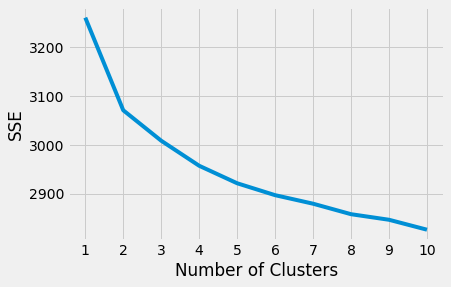

In [99]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [100]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [243]:
# To do: label docs to cluster, match new query to cluster and retrieve docs in that cluster

## ^ Not sure if this method makes sense? Like if we alr have the embeddings for each sentence, is there any benefit of clustering over direct cosine similarity?

## Method 8: Topic Modelling (LDA)
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [101]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [102]:
sentences = list(df['extractive_summarized_3_sent'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(sentences))

print(data_words[:1])

[['first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new', 'york', 'last', 'capital', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', 'assembly', 'congress', 'confederation', 'made', 'new', 'york', 'national', 'capital', 'shortly', 'war']]


In [103]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new_york', 'last', 'capital', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', 'assembly', 'congress', 'confederation', 'made', 'new_york', 'national', 'capital', 'shortly', 'war']


In [104]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [105]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [106]:
print(data_words_bigrams[:1])

[['first', 'president', 'united', 'state', 'george', 'washington', 'inaugurated', 'first', 'united', 'state', 'congress', 'supreme', 'court', 'united', 'state', 'assembled', 'first', 'time', 'united', 'state', 'bill', 'right', 'drafted', 'federal', 'hall', 'wall', 'street', 'new_york', 'last', 'capital', 'article', 'confederation', 'first', 'capital', 'constitution', 'united', 'state', 'assembly', 'congress', 'confederation', 'made', 'new_york', 'national', 'capital', 'shortly', 'war']]


In [107]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3), (5, 2), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 4), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 5), (23, 1), (24, 1), (25, 1), (26, 5), (27, 1), (28, 1), (29, 1)]]


### Building LDA Mallet Model

In [109]:
import os
os.environ.update({'MALLET_HOME':'C:/Users/User/Documents/GitHub/tmproj/document_retrieval/lda_mallet/mallet-2.0.8/'})

mallet_path = 'C:/Users/User/Documents/GitHub/tmproj/document_retrieval/lda_mallet/mallet-2.0.8/bin/mallet' # update this path

### Training LDA Mallet with Optimal Number of Topics

In [110]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [111]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

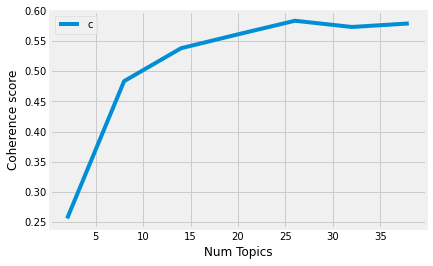

In [310]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [311]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2558
Num Topics = 8  has Coherence Value of 0.4835
Num Topics = 14  has Coherence Value of 0.5382
Num Topics = 20  has Coherence Value of 0.5612
Num Topics = 26  has Coherence Value of 0.5837
Num Topics = 32  has Coherence Value of 0.5734
Num Topics = 38  has Coherence Value of 0.5792


In [312]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(9,
  '0.023*"john" + 0.014*"woman" + 0.013*"death" + 0.013*"king" + '
  '0.013*"family" + 0.010*"royal" + 0.010*"men" + 0.008*"father" + 0.008*"son" '
  '+ 0.007*"william"'),
 (20,
  '0.047*"language" + 0.035*"term" + 0.027*"form" + 0.022*"english" + '
  '0.022*"word" + 0.019*"character" + 0.014*"common" + 0.012*"standard" + '
  '0.011*"meaning" + 0.011*"written"'),
 (10,
  '0.027*"company" + 0.025*"million" + 0.022*"world" + 0.020*"country" + '
  '0.019*"development" + 0.014*"economic" + 0.014*"industry" + 0.012*"market" '
  '+ 0.011*"billion" + 0.010*"economy"'),
 (16,
  '0.029*"th_century" + 0.024*"de" + 0.021*"early" + 0.020*"began" + '
  '0.019*"india" + 0.018*"european" + 0.017*"europe" + 0.016*"late" + '
  '0.015*"end" + 0.014*"established"'),
 (23,
  '0.047*"population" + 0.044*"people" + 0.024*"american" + 0.019*"group" + '
  '0.018*"community" + 0.018*"black" + 0.018*"number" + 0.016*"country" + '
  '0.015*"white" + 0.015*"child"'),
 (6,
  '0.055*"state" + 0.033*"law" + 0.0

In [331]:
## Save optimal LDA model as pkl file

# pickle.dump(optimal_model, open("lda_mallet/lda_optimal_model_2_apr.pkl", "wb"))

In [9]:
# Load optimal LDA model
optimal_lda_loaded = pickle.load(open("lda_mallet/lda_optimal_model_2_apr.pkl", "rb"))

### Finding the dominant topic in each sentence

In [19]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_lda_loaded, corpus=corpus, texts=data_words_bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.3502,"music, record, work, house, number, song, popular, artist, single, album","[born, raised, houston, texas, performed, various, singing, dancing, competition, child, rose, fame, late, lead, singer, girl, group, destiny_child, hiatus, saw, release, beyonce, debut_album, dangerously, love, established, solo_artist, worldwide, earned, five, grammy_award, featured, billboard_hot, number, one, single, crazy, love, baby, boy, beyonce, giselle, knowles, carter, bi, jansei, bee, yon, say, born, september, american, singer_songwriter, record, producer, actress]"
1,1,17.0,0.3887,"music, record, work, house, number, song, popular, artist, single, album","[beyonce, took, hiatus, music, took, management, career, fourth, album, subsequently, mellower, tone, exploring, funk, pop, soul, marriage, rapper, jay, portrayal, etta, james, cadillac, record, influenced, third, album, sasha_fierce, saw, birth, alter, ego, sasha_fierce, earned, record, setting, six, grammy_award, including, song, year, single, lady_put, ring, critically, acclaimed, fifth, studio_album, beyonce, distinguished, previous, release, experimental, production, exploration, darker, theme]"
2,2,17.0,0.2720,"music, record, work, house, number, song, popular, artist, single, album","[throughout, career, spanning, year, sold, million, record, solo_artist, million, destiny_child, making, one, best_selling, music, artist, time, stage, dynamic, highly, choreographed, performance, led, critic, hailing, one, best, entertainer, contemporary, popular, music, self, described, modern, day, feminist, beyonce, creates, song, often, characterized, theme, love, relationship, monogamy, well, female, sexuality, empowerment]"


In [20]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,17.0,0.3502,"music, record, work, house, number, song, popular, artist, single, album","[born, raised, houston, texas, performed, various, singing, dancing, competition, child, rose, fame, late, lead, singer, girl, group, destiny_child, hiatus, saw, release, beyonce, debut_album, dangerously, love, established, solo_artist, worldwide, earned, five, grammy_award, featured, billboard_hot, number, one, single, crazy, love, baby, boy, beyonce, giselle, knowles, carter, bi, jansei, bee, yon, say, born, september, american, singer_songwriter, record, producer, actress]"
1,17.0,0.3887,"music, record, work, house, number, song, popular, artist, single, album","[beyonce, took, hiatus, music, took, management, career, fourth, album, subsequently, mellower, tone, exploring, funk, pop, soul, marriage, rapper, jay, portrayal, etta, james, cadillac, record, influenced, third, album, sasha_fierce, saw, birth, alter, ego, sasha_fierce, earned, record, setting, six, grammy_award, including, song, year, single, lady_put, ring, critically, acclaimed, fifth, studio_album, beyonce, distinguished, previous, release, experimental, production, exploration, darker, theme]"
2,17.0,0.2720,"music, record, work, house, number, song, popular, artist, single, album","[throughout, career, spanning, year, sold, million, record, solo_artist, million, destiny_child, making, one, best_selling, music, artist, time, stage, dynamic, highly, choreographed, performance, led, critic, hailing, one, best, entertainer, contemporary, popular, music, self, described, modern, day, feminist, beyonce, creates, song, often, characterized, theme, love, relationship, monogamy, well, female, sexuality, empowerment]"
3,17.0,0.1815,"music, record, work, house, number, song, popular, artist, single, album","[beyonce, giselle, knowles, born, houston, texas, celestine, ann, tina, knowles, nee, beyince, hairdresser, salon, owner, mathew, knowles, xerox, sale, manager, beyonce, name, tribute, mother, maiden, name, beyonce, younger, sister, solange, also, singer, former, member, destiny_child]"
4,17.0,0.2467,"music, record, work, house, number, song, popular, artist, single, album","[fall, beyonce, enrolled, parker, elementary_school, music, magnet, school, houston, would, perform, school, choir, beyonce, interest, music, performing, continued, winning, school, talent, show, age, seven, singing, john_lennon, imagine, beat, year, old, singing, talent, discovered, dance, instructor, darlette, johnson, began, humming, song, finished, able, hit, high, pitched, note]"
...,...,...,...,...
18872,1.0,0.3722,"university, school, national, college, student, education, public, including, research, building","[number, medical, college, including, kathmandu, medical, college, nepal, medical, college, kist, medical, college, nepal, army, institute, health, science, national, academy, medical, science, nams, kathmandu, university, school, medical, science, kusms, also, located, around, kathmandu, institute, medicine, central, college, tribhuwan, university, first, medical, college, nepal, located, maharajgunj, kathmandu, established, started, impart, medical, education]"
18873,19.0,0.1942,"world, game, team, season, club, league, year, series, home, final","[international, football, stadium, city, dasarath, rangasala, stadium, multi, purpose, stadium, used, mostly, football, match, cultural, event, located, neighborhood, tripureshwor, football, cricket, popular, sport, among, younger, generation, nepal, several, stadium, city, stadium, renovated, chinese, help, th, south, asian, game, held, kathmandu, floodlight, installed]"
18874,10.0,0.1158,"company, million, world, country, development, economic, industry, market, billion, economy","[fairly, large, network, helped, economic, development, country, particularly, field, agriculture, horticulture, vegetable, farming, industry, also, tourism, view, hilly, terrain, transportation, take_place, kathmandu,

### Find the most representative document for each topic

In [21]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3762,"th_century, greek, period, modern, early, century, roman, culture, bc, building","[notable, modern, greek, artist, include, renaissance, painter, dominikos, theotokopoulos, el, greco, panagiotis, doxaras, nikolaos, gyzis, nikiphoros, lytras, yannis, tsarouchis, nikos, engonopoulos, constantine, andreou, jannis, kounellis, sculptor, leonidas, drosis, georgios, bonanos, yannoulis, chalepas, joannis, avramidis, conductor, dimitri, mitropoulos, soprano, maria, calla, composer, mikis, theodorakis, nikos, skalkottas, iannis, xenakis, manos, hatzidakis, eleni, karaindrou, yanni, vangelis, one, best_selling, singer, worldwide, nana, mouskouri, poet, kostis, palamas, dionysios, solomos, angelos, sikelianos, yannis, ritsos, alexandrian, constantine, cavafy, nobel_laureate, giorgos, seferis, odysseas, elytis, among, important, poet, th_century, novel, also, represented, alexandros, papadiamantis, nikos, kazantzakis]"
1,1.0,0.5058,"university, school, national, college, student, education, public, including, research, building","[year, later, university, north_carolina, system, encompasses, public, university, including, north_carolina, state, university, north_carolina, state, university, north_carolina, central, university, university, north_carolina, chapel_hill, university, north_carolina, greensboro, east, carolina, university, western, carolina, university, winston_salem, state, university, university, north_carolina, asheville, university, north_carolina, charlotte, university, north_carolina, pembroke, unc, wilmington, elizabeth, city, state, university, appalachian, state, university, fayetteville, state, university, unc, school, art, along, public, university, north_carolina, public, community, college, community, college, system, largest, university, north_carolina, currently, north_carolina, state, university, student, north_carolina, home, many, excellent, university, well, dozen, community, college, private, university]"
2,2.0,0.4185,"empire, french, german, power, france, war, germany, part, paris, state","[ottoman_empire, at, ottoman, turkish, dawlati, aliywh, uthmaniywh, devlet, aliyye, osmaniyye, modern, turkish, osmanli, imparatorlugu, osmanli, devleti, also, known, turkish, empire, ottoman, turkey, turkey, empire, founded, oghuz, turk, osman, northwestern, anatolia, conquest, balkan, murad, ottoman, sultanate, transformed, empire, claimant, caliphate, ottoman, ended, byzantine_empire, conquest, constantinople, mehmed, conqueror]"
3,3.0,0.4221,"high, due, film, current, level, le, low, result, rate, higher","[addition, lower, radiation_resistance, reactance, becomes, higher, antenna, size, reduced, resonant, circuit, formed, antenna, tuning, coil, factor, rise, eventually, cause, bandwidth, antenna, inadequate, signal, transmitted, example, mhz, wavelength, true, resonant, wavelength, monopole, would, almost, meter, long, using, antenna, meter, tall, would, require, addition, loading, coil, however, resulting, resistive, impedance, achieved, quite, bit, lower, impedance, resonant, monopole, likely, requiring, impedance_matching]"
4,4.0,0.4447,"water, energy, material, form, source, process, power, made, wood, mass","[ortho, para, ratio, condensed, important, consideration, preparation, storage, liquid, hydrogen, conversion, ortho, para, exothermic, produce, enough, heat, evaporate, hydrogen, liquid, leading, loss, liquefied, material, uncatalyzed, interconversion, para, ortho, increase, increasing, temperature, thus, rapidly, condensed, contains, large, quantity, high, energy, ortho, form, convert, para, form, slowly, catalyst, ortho, para, interconversion, ferric, oxide, activated, carbon, platinized, asbestos, rare, earth, metal, uranium, compound, chromic, oxide, nickel, compound, used, hydrogen, cooling]"
5,5.0,0.4140,"specie, plant, human, found, animal, group, life, bird, including, number","[montana, department, fish_wildlife, park, manages, fishing, hunti

## Get Law Related Docs
Obtain legal subset for demo

In [30]:
df.iloc[df_topic_sents_keywords[df_topic_sents_keywords['Dominant_Topic']==6].index, :].to_csv('squad_legal_paras_lda.csv')

### Topic distribution across documents

In [364]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum()*100, 2).astype(str) + '%'

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"th_century, greek, period, modern, early, century, roman, culture, bc, building",844,4.47%
1.0,1.0,"university, school, national, college, student, education, public, including, research, building",796,4.22%
2.0,2.0,"empire, french, german, power, france, war, germany, part, paris, state",846,4.48%
3.0,3.0,"high, due, film, current, level, le, low, result, rate, higher",325,1.72%
4.0,4.0,"water, energy, material, form, source, process, power, made, wood, mass",725,3.84%
5.0,5.0,"specie, plant, human, found, animal, group, life, bird, including, number",622,3.3%
6.0,6.0,"state, law, government, party, president, court, federal, member, political, council",1080,5.72%
7.0,7.0,"force, war, army, military, general, battle, operation, attack, british, air",1043,5.53%
8.0,8.0,"year, time, day, average, month, event, hour, long, space, july",476,2.52%
9.0,9.0,"john, woman, death, king, family, royal, men, father, son, william",754,3.99%


### Finding dominant topic of a new query
https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

In [393]:
def get_query_topic(query):
    tokens = clean_lowercase_nostop_lem(query).split()
    scores = sorted(optimal_lda_loaded[id2word.doc2bow(tokens)], key=lambda x: x[1], reverse=True)
    for i in scores:
        print(f"Topic: {i[0]}, Score: {str(round(i[1]*100,2)) + '%'}, Top Keywords: {df_dominant_topics.iloc[i[0],1].split()[:3]}")
    return scores[0][0]

In [394]:
get_query_topic('obama was the president of the united states')

Topic: 6, Score: 6.85%, Top Keywords: ['state,', 'law,', 'government,']
Topic: 13, Score: 5.41%, Top Keywords: ['order,', 'member,', 'policy,']
Topic: 15, Score: 5.41%, Top Keywords: ['country,', 'china,', 'government,']
Topic: 19, Score: 3.77%, Top Keywords: ['world,', 'game,', 'team,']
Topic: 2, Score: 3.77%, Top Keywords: ['empire,', 'french,', 'german,']
Topic: 0, Score: 3.56%, Top Keywords: ['th_century,', 'greek,', 'period,']
Topic: 1, Score: 3.56%, Top Keywords: ['university,', 'school,', 'national,']
Topic: 3, Score: 3.56%, Top Keywords: ['high,', 'due,', 'film,']
Topic: 4, Score: 3.56%, Top Keywords: ['water,', 'energy,', 'material,']
Topic: 5, Score: 3.56%, Top Keywords: ['specie,', 'plant,', 'human,']
Topic: 7, Score: 3.56%, Top Keywords: ['force,', 'war,', 'army,']
Topic: 8, Score: 3.56%, Top Keywords: ['year,', 'time,', 'day,']
Topic: 9, Score: 3.56%, Top Keywords: ['john,', 'woman,', 'death,']
Topic: 10, Score: 3.56%, Top Keywords: ['company,', 'million,', 'world,']
Topic

6